# FICO Classifier #
You need to create a rating map that maps the FICO score of the borrowers to a rating where a lower rating signifies a better credit score. The process of doing this is known as quantization. You could consider many ways of solving the problem by optimizing different properties of the resulting buckets, such as the mean squared error or log-likelihood (see below for definitions).

In [163]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.optimize import minimize

In [164]:
# Loading dataset
fico_df = pd.read_csv('credit_data.csv')
print(fico_df)
fico_scores = fico_df['fico_score']
default_labels = fico_df['default']

      customer_id  credit_lines_outstanding  ...  fico_score  default
0         8153374                         0  ...         605        0
1         7442532                         5  ...         572        1
2         2256073                         0  ...         602        0
3         4885975                         0  ...         612        0
4         4700614                         1  ...         631        0
...           ...                       ...  ...         ...      ...
9995      3972488                         0  ...         697        0
9996      6184073                         1  ...         615        0
9997      6694516                         2  ...         596        0
9998      3942961                         0  ...         647        0
9999      5533570                         1  ...         757        0

[10000 rows x 8 columns]


In [165]:
# Initialize 4 buckets for simplicity
num_buckets = 4
fico_df['bucket'] = pd.cut (fico_df['fico_score'], bins=num_buckets, labels=False)
print(fico_df)

      customer_id  credit_lines_outstanding  ...  default  bucket
0         8153374                         0  ...        0       1
1         7442532                         5  ...        1       1
2         2256073                         0  ...        0       1
3         4885975                         0  ...        0       1
4         4700614                         1  ...        0       2
...           ...                       ...  ...      ...     ...
9995      3972488                         0  ...        0       2
9996      6184073                         1  ...        0       1
9997      6694516                         2  ...        0       1
9998      3942961                         0  ...        0       2
9999      5533570                         1  ...        0       3

[10000 rows x 9 columns]


## Initializing our classifier ##

In [166]:
# Initialize the boundaries

def log_likelihood(data):
    log_likelihood = 0
    for bucket in range(num_buckets):
        bucket_data = data[data['bucket'] == bucket]
        if not bucket_data.empty:
            k_i = bucket_data['default'].sum()
            n_i = len(bucket_data)
            p_i = k_i / n_i if n_i > 0 else 0
            log_likelihood += binom.logpmf(k_i, n_i, p_i)
    return log_likelihood

initial_llh = log_likelihood(fico_df)
print(f'Initial Log-Likelihood: {initial_llh}')

Initial Log-Likelihood: -13.463435690607817


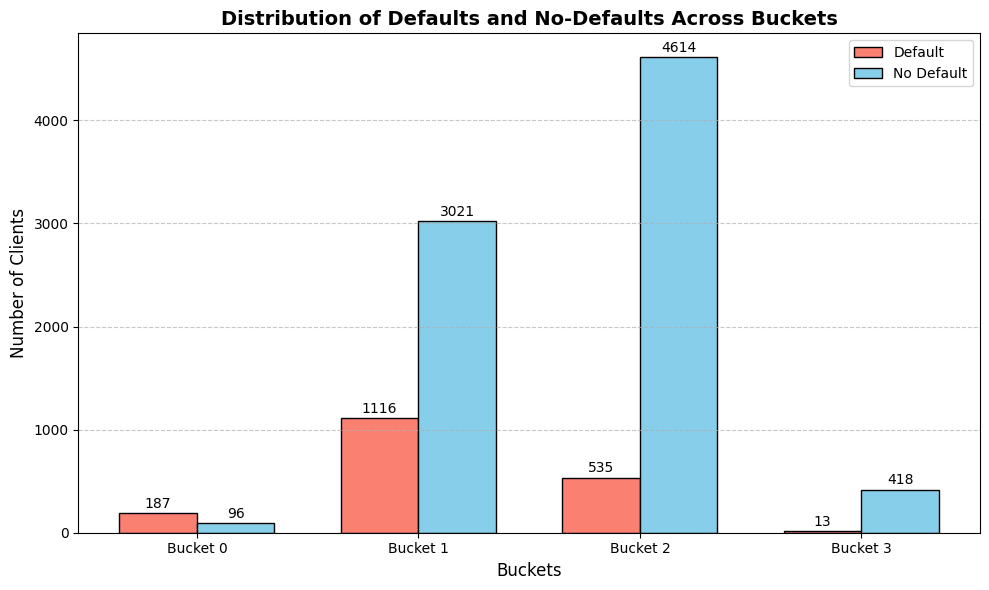

In [167]:
# Prepare data for the bar plot
bucket_labels = [f'Bucket {b}' for b in range(num_buckets)]
default_counts = []
no_default_counts = []

for b in range(num_buckets):
    bucket_data = fico_df[fico_df['bucket'] == b]
    default_counts.append(bucket_data['default'].sum())  # Count of defaults
    no_default_counts.append(len(bucket_data) - bucket_data['default'].sum())  # Count of no-defaults

# Bar plot for default and no-default counts
x = np.arange(num_buckets)  # The label locations
width = 0.35  # Width of the bars

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width / 2, default_counts, width, label='Default', color='salmon', edgecolor='black')
bars2 = plt.bar(x + width / 2, no_default_counts, width, label='No Default', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Buckets', fontsize=12)
plt.ylabel('Number of Clients', fontsize=12)
plt.title('Distribution of Defaults and No-Defaults Across Buckets', fontsize=14, fontweight='bold')
plt.xticks(x, bucket_labels, fontsize=10)
plt.legend()

# Display counts on top of bars
for bar in bars1:  # For default counts
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 50, f'{height}', ha='center', fontsize=10)

for bar in bars2:  # For no-default counts
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 50, f'{height}', ha='center', fontsize=10)

# Add grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Optimizing our classifier ##

In [168]:
def optimize_buckets(df, num_buckets, max_iterations=100):
    boundaries = np.linspace(df['fico_score'].min(), df['fico_score'].max(), num_buckets + 1)
    best_llh = log_likelihood(df)
    improved = True
    iteration = 0

    while improved and iteration < max_iterations:
        improved = False
        for i in range(1, len(boundaries) - 1):  # Avoid modifying the first/last boundaries
            original_boundary = boundaries[i]
            for shift in [-10, 10]:  # Test larger ranges for boundary adjustments
                boundaries[i] += shift
                # Ensure boundaries remain valid
                if boundaries[i] <= boundaries[i-1] or boundaries[i] >= boundaries[i+1]:
                    boundaries[i] = original_boundary
                    continue
                df['bucket'] = pd.cut(df['fico_score'], bins=boundaries, labels=False, include_lowest=True)
                new_llh = log_likelihood(df)
                if new_llh > best_llh:
                    best_llh = new_llh
                    improved = True
                else:
                    boundaries[i] = original_boundary  # Revert if no improvement
        iteration += 1
        print(f"Iteration {iteration}: Best log likelihood = {best_llh}, Boundaries = {boundaries}")

    # Recalculate log-likelihood for final boundaries
    df['bucket'] = pd.cut(df['fico_score'], bins=boundaries, labels=False, include_lowest=True)
    final_llh = log_likelihood(df)
    print(f"Final Boundaries: {boundaries}, Final Log Likelihood: {final_llh}")

    return boundaries



In [169]:
final_boundaries = optimize_buckets(fico_df, num_buckets)
fico_df['bucket'] = pd.cut(fico_df['fico_score'], bins=final_boundaries, labels=False, include_lowest=True)
print(f'\nFinal boundaries are: \nBucket 1: {final_boundaries[0]} to {final_boundaries[1]} \nBucket 2: {final_boundaries[1]} to {final_boundaries[2]} \nBucket 3: {final_boundaries[2]} to {final_boundaries[3]} \nBucket 4: {final_boundaries[3]} to {final_boundaries[4]}\n')
print(fico_df)

Iteration 1: Best log likelihood = -13.231444113070069, Boundaries = [408.  518.5 629.  749.5 850. ]
Iteration 2: Best log likelihood = -12.903555593217746, Boundaries = [408.  518.5 629.  759.5 850. ]
Iteration 3: Best log likelihood = -12.74867211723064, Boundaries = [408.  518.5 629.  759.5 850. ]
Iteration 4: Best log likelihood = -12.74867211723064, Boundaries = [408.  518.5 629.  759.5 850. ]
Final Boundaries: [408.  518.5 629.  759.5 850. ], Final Log Likelihood: -12.903555593217746

Final boundaries are: 
Bucket 1: 408.0 to 518.5 
Bucket 2: 518.5 to 629.0 
Bucket 3: 629.0 to 759.5 
Bucket 4: 759.5 to 850.0

      customer_id  credit_lines_outstanding  ...  default  bucket
0         8153374                         0  ...        0       1
1         7442532                         5  ...        1       1
2         2256073                         0  ...        0       1
3         4885975                         0  ...        0       1
4         4700614                         1  ..

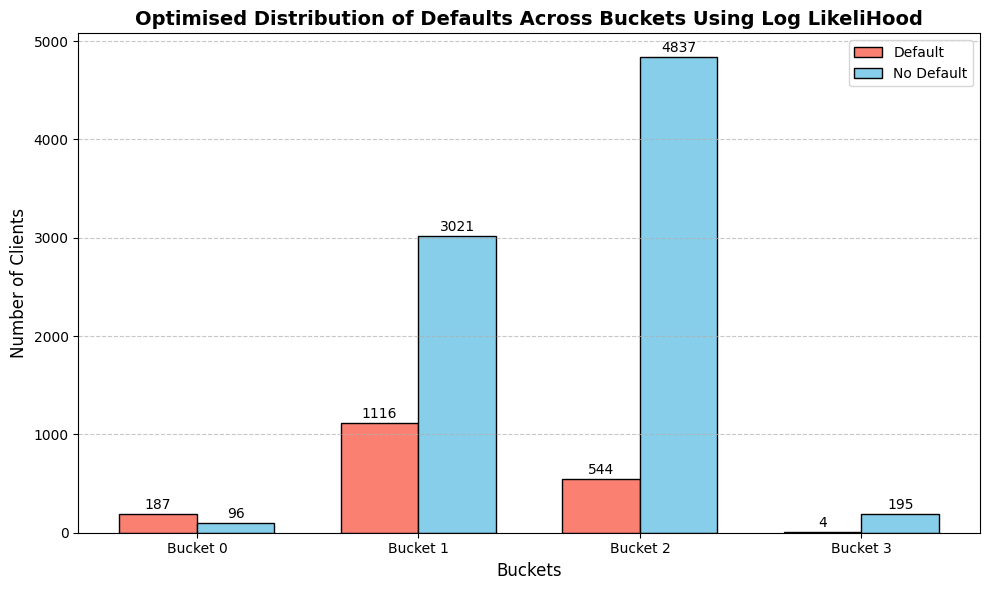

In [170]:
# Prepare data for the bar plot
bucket_labels = [f'Bucket {b}' for b in range(num_buckets)]
default_counts = []
no_default_counts = []

for b in range(num_buckets):
    bucket_data = fico_df[fico_df['bucket'] == b]
    default_counts.append(bucket_data['default'].sum())  # Count of defaults
    no_default_counts.append(len(bucket_data) - bucket_data['default'].sum())  # Count of no-defaults

# Bar plot for default and no-default counts
x = np.arange(num_buckets)  # The label locations
width = 0.35  # Width of the bars

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width / 2, default_counts, width, label='Default', color='salmon', edgecolor='black')
bars2 = plt.bar(x + width / 2, no_default_counts, width, label='No Default', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Buckets', fontsize=12)
plt.ylabel('Number of Clients', fontsize=12)
plt.title('Optimised Distribution of Defaults Across Buckets Using Log LikeliHood', fontsize=14, fontweight='bold')
plt.xticks(x, bucket_labels, fontsize=10)
plt.legend()

# Display counts on top of bars
for bar in bars1:  # For default counts
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 50, f'{height}', ha='center', fontsize=10)

for bar in bars2:  # For no-default counts
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 50, f'{height}', ha='center', fontsize=10)

# Add grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Optimizing the number of buckets ##

In [171]:
def optimize_bucket_count (data, min_buckets, max_buckets): 
    best_overall_llh = float('-inf')
    best_bucket_count = min_buckets
    best_boundaries = None
    
    for num_buckets in range(min_buckets, max_buckets + 1):
        
        print(f"Testing {num_buckets} buckets...")
        boundaries = np.linspace(data['fico_score'].min(), data['fico_score'].max(), num_buckets + 1)
        data['bucket'] = pd.cut(data['fico_score'], bins=boundaries, labels=False, include_lowest=True)
        initial_llh = log_likelihood(data)
        
        boundaries = optimize_buckets(data, num_buckets)
        data['bucket'] = pd.cut(data['fico_score'], bins=boundaries, labels=False, include_lowest=True)
        final_llh = log_likelihood(data)
        
        print(f'Boundaries for {num_buckets} buckets: {boundaries}')
        print(f'Log likelihood for {num_buckets} buckets: llh = {final_llh:.2f}')
        
        if final_llh > best_overall_llh:
            best_overall_llh = final_llh
            best_bucket_count = num_buckets
            best_boundaries = boundaries
            
    return best_bucket_count, best_boundaries, best_overall_llh

best_bucket_count, best_boundaries, best_overall_llh = optimize_bucket_count(fico_df, 4, 10)
print(f'Best number of buckets: {best_bucket_count}, with a likelihood of {best_overall_llh:.2f}')

Testing 4 buckets...
Iteration 1: Best log likelihood = -13.231444113070069, Boundaries = [408.  518.5 629.  749.5 850. ]
Iteration 2: Best log likelihood = -12.903555593217746, Boundaries = [408.  518.5 629.  759.5 850. ]
Iteration 3: Best log likelihood = -12.74867211723064, Boundaries = [408.  518.5 629.  759.5 850. ]
Iteration 4: Best log likelihood = -12.74867211723064, Boundaries = [408.  518.5 629.  759.5 850. ]
Final Boundaries: [408.  518.5 629.  759.5 850. ], Final Log Likelihood: -12.903555593217746
Boundaries for 4 buckets: [408.  518.5 629.  759.5 850. ]
Log likelihood for 4 buckets: llh = -12.90
Testing 5 buckets...
Iteration 1: Best log likelihood = -13.979545291439944, Boundaries = [408.  496.4 584.8 673.2 761.6 850. ]
Iteration 2: Best log likelihood = -13.979545291439944, Boundaries = [408.  496.4 584.8 673.2 761.6 850. ]
Final Boundaries: [408.  496.4 584.8 673.2 761.6 850. ], Final Log Likelihood: -14.171340233241736
Boundaries for 5 buckets: [408.  496.4 584.8 673.

In [175]:
fico_df['bucket'] = pd.cut(fico_df['fico_score'], bins=best_boundaries, labels=False, include_lowest=True)
print(f'\nFinal boundaries are: {best_boundaries}')
print(fico_df)


Final boundaries are: [408.  452.2 496.4 540.6 584.8 629.  673.2 717.4 761.6 805.8 850. ]
      customer_id  credit_lines_outstanding  ...  default  bucket
0         8153374                         0  ...        0       4
1         7442532                         5  ...        1       3
2         2256073                         0  ...        0       4
3         4885975                         0  ...        0       4
4         4700614                         1  ...        0       5
...           ...                       ...  ...      ...     ...
9995      3972488                         0  ...        0       6
9996      6184073                         1  ...        0       4
9997      6694516                         2  ...        0       4
9998      3942961                         0  ...        0       5
9999      5533570                         1  ...        0       7

[10000 rows x 9 columns]


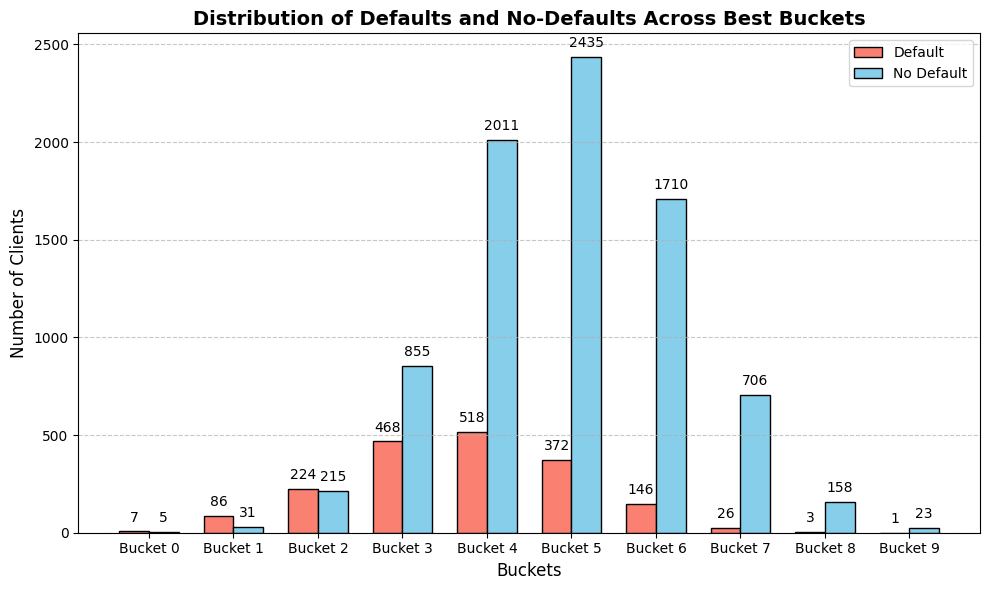

In [176]:
# Prepare data for the bar plot using the best boundaries
bucket_labels = [f'Bucket {i}' for i in range(len(best_boundaries) - 1)]
default_counts = []
no_default_counts = []

for i in range(len(best_boundaries) - 1):
    bucket_data = fico_df[fico_df['bucket'] == i]
    default_counts.append(bucket_data['default'].sum())  # Count of defaults
    no_default_counts.append(len(bucket_data) - bucket_data['default'].sum())  # Count of no-defaults

# Bar plot for default and no-default counts
x = np.arange(len(best_boundaries) - 1)  # The label locations
width = 0.35  # Width of the bars

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width / 2, default_counts, width, label='Default', color='salmon', edgecolor='black')
bars2 = plt.bar(x + width / 2, no_default_counts, width, label='No Default', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Buckets', fontsize=12)
plt.ylabel('Number of Clients', fontsize=12)
plt.title('Distribution of Defaults and No-Defaults Across Best Buckets', fontsize=14, fontweight='bold')
plt.xticks(x, bucket_labels, fontsize=10)
plt.legend()

# Display counts on top of bars
for bar in bars1:  # For default counts
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 50, f'{height}', ha='center', fontsize=10)

for bar in bars2:  # For no-default counts
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 50, f'{height}', ha='center', fontsize=10)

# Add grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()